### Section 1.4.4 Linear Regulator
Taken from "Switch-Mode Power Supplies" by Christophe P. Basso

In [1]:
# Project selection

MY_PROJECT: str = "sec_1_04_04"  # which section of config file to use

In [2]:
# Imports, type aliases

import copy
import tomllib
from pathlib import Path
from typing import Any

import numpy as np
import numpy.typing as npt
import py4spice as spi

# Aliases for type checking
from py4spice.globals_types import numpy_flt

In [3]:
# Constants


class Key:
    """Keys for dictionaries.  Defined here at top level so they can be
    referenced instead of using strings for keys.
    """

    # Keys for decoding the config file
    CONFIG_NAME = "config_name"
    GLOBAL_SECTION = "global_section"
    NGSPICE_EXE_KEY = "ngspice_exe_str"
    NETLISTS_DIR_KEY = "netlists_dir_str"
    RESULTS_DIR_KEY = "results_dir_str"
    SIM_TRANSCRIPT_KEY = "sim_transcript_str"
    PROJ_PATH_KEY = "proj_path_str"
    PROJ_SECTION = "proj_section"

    # Keys for the paths_dict
    NGSPICE_EXE = "ngspice_exe"
    PROJ_PATH = "proj_path"
    NETLISTS_PATH = "netlists_path"
    RESULTS_PATH = "results_path"
    SIM_TRANSCRIPT_FILENAME = "sim_transcript_filename"

    # Keys for the netlists_dict
    BLANKLINE = "blankline"
    TITLE = "title"
    END_LINE = "end_line"
    LOAD1 = "load1"
    LOAD2 = "load2"
    LOAD3 = "load3"
    LOAD4 = "load4"
    LOAD5 = "load5"
    LOAD6 = "load6"
    LOAD7 = "load7"
    STIMULUS1 = "stimulus1"
    STIMULUS2 = "stimulus2"
    STIMULUS3 = "stimulus3"
    STIMULUS4 = "stimulus4"
    STIMULUS5 = "stimulus5"
    STIMULUS6 = "stimulus6"
    STIMULUS7 = "stimulus7"
    SUPPLIES = "supplies"
    MODELS = "models"
    DUT = "dut"
    RC = "rc"
    RF = "rf"
    CF = "cf"
    RF_470K = "rf_470k"
    COUT = "cout"
    CONTROL1 = "control1"
    CONTROL2 = "control2"
    CONTROL3 = "control3"
    CONTROL4 = "control4"
    CONTROL5 = "control5"
    CONTROL6 = "control6"
    CONTROL7 = "control7"
    TOP1 = "top1"
    TOP2 = "top2"
    TOP3 = "top3"
    TOP4 = "top4"
    TOP5 = "top5"
    TOP6 = "top6"
    TOP7 = "top7"

    # Keys for the vectors_dict
    VEC_ALL = "vec_all"
    VEC_IN_OUT = "vec_in_out"
    VEC_OUT = "vec_out"
    VEC_GAIN = "vec_gain"


# Dictionary for decoding the config file. These keys match the name is the config file
# DO NOT CHANGE unless you change the keys in the config file
config_file_decoding = {
    Key.CONFIG_NAME: "/workspaces/sw_pwr_book_sim/python/config.toml",
    Key.GLOBAL_SECTION: "global",
    Key.PROJ_SECTION: MY_PROJECT,
    Key.NGSPICE_EXE_KEY: "ngspice_exe_str",
    Key.NETLISTS_DIR_KEY: "netlists_dir_str",
    Key.RESULTS_DIR_KEY: "results_dir_str",
    Key.SIM_TRANSCRIPT_KEY: "sim_transcript_str",
    Key.PROJ_PATH_KEY: "proj_path_str",
}

In [4]:
# Initialization

def initialize() -> tuple[dict[str, Path], dict[str, spi.Netlist], dict[str, spi.Vectors]]:

    # read config file and create config dictionary
    config_filename: Path = Path(config_file_decoding[Key.CONFIG_NAME])
    with open(config_filename, "rb") as file:
        my_config: dict[str, Any] = tomllib.load(file)

    # Decodings for the config dictionary, which came from the config file
    config_global_section: str = config_file_decoding[Key.GLOBAL_SECTION]
    config_ngspice_exe_key: str = config_file_decoding[Key.NGSPICE_EXE_KEY]
    config_netlists_dir_key: str = config_file_decoding[Key.NETLISTS_DIR_KEY]
    config_results_dir_key: str = config_file_decoding[Key.RESULTS_DIR_KEY]
    config_sim_transcript_key: str = config_file_decoding[Key.SIM_TRANSCRIPT_KEY]
    config_proj_path_key: str = config_file_decoding[Key.PROJ_PATH_KEY]
    config_proj_section: str = config_file_decoding[Key.PROJ_SECTION]

    # Create paths based on the config dictionary
    ngspice_exe: Path = Path(my_config[config_global_section][config_ngspice_exe_key])
    proj_path: Path = Path(my_config[config_proj_section][config_proj_path_key])
    netlists_path: Path = (
        proj_path / my_config[config_global_section][config_netlists_dir_key]
    )
    results_path: Path = (
        proj_path / my_config[config_global_section][config_results_dir_key]
    )

    # create results directory if it does not exist
    results_path.mkdir(parents=True, exist_ok=True)

    # create simlulation transcript file. If it exists, make sure it is empty
    sim_tran_filename: Path = (
        results_path / my_config[config_global_section][config_sim_transcript_key]
    )
    if sim_tran_filename.exists():  # delete and recreate. this makes sure it's empty
        sim_tran_filename.unlink()
    sim_tran_filename.touch()

    # create paths dictionary
    paths_dict = {
        Key.NGSPICE_EXE: ngspice_exe,
        Key.PROJ_PATH: proj_path,
        Key.NETLISTS_PATH: netlists_path,
        Key.RESULTS_PATH: results_path,
        Key.SIM_TRANSCRIPT_FILENAME: sim_tran_filename,
    }

    # netlists_dict = define_netlists(paths_dict)
    netlists_path: Path = paths_dict[Key.NETLISTS_PATH]  # make shorter alias
    netlists_dict: dict[str, spi.Netlist] = {}  # create empty netlist dictionary

    netlists_dict[Key.BLANKLINE] = spi.Netlist("")  # blank line for spacing
    netlists_dict[Key.TITLE] = spi.Netlist("* Title line")  # title line
    netlists_dict[Key.END_LINE] = spi.Netlist(".end")  # end statement

    # create netlist objects from files and add to netlist dictionary
    netlists_dict[Key.DUT] = spi.Netlist(netlists_path / "dut.cir")
    netlists_dict[Key.LOAD1] = spi.Netlist(netlists_path / "load_resistive.cir")
    netlists_dict[Key.LOAD2] = spi.Netlist(netlists_path / "load_resistive.cir")
    netlists_dict[Key.LOAD3] = spi.Netlist(netlists_path / "load_current_pulse.cir")
    netlists_dict[Key.LOAD4] = spi.Netlist(netlists_path / "load_current_ac.cir")
    netlists_dict[Key.LOAD5] = spi.Netlist(netlists_path / "load_current_ac.cir")
    netlists_dict[Key.STIMULUS1] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS2] = spi.Netlist(netlists_path / "stimulus_15v_ramp.cir")
    netlists_dict[Key.STIMULUS3] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS4] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS5] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS6] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.STIMULUS7] = spi.Netlist(netlists_path / "stimulus_15v_dc.cir")
    netlists_dict[Key.SUPPLIES] = spi.Netlist(netlists_path / "supplies.cir")
    netlists_dict[Key.MODELS] = spi.Netlist(netlists_path / "models.cir")
    netlists_dict[Key.RC] = spi.Netlist(netlists_path / "rc_compensation.cir")
    netlists_dict[Key.COUT] = spi.Netlist(netlists_path / "filter_cap.cir")

    # Define a vector dictionary for simulation and post-simulation analysis
    vectors_dict = {
        Key.VEC_ALL: spi.Vectors("all"),
        Key.VEC_IN_OUT: spi.Vectors("in out"),
        Key.VEC_OUT: spi.Vectors("out"),
        Key.VEC_GAIN: spi.Vectors("20*log10(mag(out))"),
    }
    return paths_dict, netlists_dict, vectors_dict

paths_dict, netlists_dict, vectors_dict = initialize()

#### Part 1: operating point and transfer function
No compensation network (Rf & Cf); vin = 15V dc; load = 50 ohms resistor.

Run the operation point ("op") and small signal transfer ("tf").

This section is executed as a function so to not conflict with variable from other parts.

In [5]:
# Part 1


def part1(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list

    # 1st analysis: operating point
    op1 = spi.Analyses(
        name="op1",
        cmd_type="op",
        cmd="op",
        vector=my_vectors_dict[Key.VEC_ALL],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(op1)

    # 2nd analysis: transfer function
    tf1 = spi.Analyses(
        name="tf1",
        cmd_type="tf",
        cmd="tf v(out) vin",
        vector=my_vectors_dict[Key.VEC_ALL],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(tf1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL1] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP1] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.LOAD1]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS1]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL1]
        + my_netlists_dict[Key.END_LINE]
        + my_netlists_dict[Key.BLANKLINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top1.cir"
    my_netlists_dict[Key.TOP1].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim1",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]

    # give each SimResults object a more descriptive name
    op1_results, tf1_results = sim_results

    # diaplay results for operating point analysis
    spi.print_section("Part 1: Operating Point Results", op1_results.table_for_print())

    # display results for small signal transfer function analysis
    spi.print_section("Part 1: Transfer Function Results", tf1_results.table_for_print())

    # fred = spi.SimResults2.from_file("op", my_paths_dict[Key.RESULTS_PATH] / "op1.txt")


    # print(fred.table_for_print())

    return my_netlists_dict


# netlists_dict = part1(paths_dict, netlists_dict, vectors_dict)

#### Part 2: transfers function calculated by stepping input voltage
No compensation network; input voltage steps from 15V to 500V. load = 50 ohms resistor.

Run a tranisent analysis.

dc audio suseptibility = delta vout / delta vin

In [6]:
# Part 2


def part2(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    tr1 = spi.Analyses(
        name="tr1",
        cmd_type="tran",
        cmd="tran 1e-9 20e-6",
        vector=my_vectors_dict[Key.VEC_ALL],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(tr1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL2] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP2] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.LOAD2]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS2]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL2]
        + my_netlists_dict[Key.END_LINE]
        + my_netlists_dict[Key.BLANKLINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top2.cir"
    my_netlists_dict[Key.TOP2].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim2",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]
    # get waveforms from sim_results
    tr1 = spi.Waveforms(sim_results[0].header, sim_results[0].data_plot)

    # limit to just "out" signal
    tr1.vec_subset(my_vectors_dict[Key.VEC_OUT].list_out())
    tr1.x_range(9e-6, 12e-6)  # limit range to just step results

    # display results
    plot_data = tr1.x_axis_and_sigs(my_vectors_dict[Key.VEC_OUT].list_out())
    y_names = my_vectors_dict[Key.VEC_OUT].list_out()
    my_plt = spi.Plot("tr_plt", plot_data, y_names, my_paths_dict[Key.RESULTS_PATH])
    my_plt.set_title("part 2 transient results")
    my_plt.define_axes(("time", "sec", "linear"), ("voltage", "V", "linear"))
    my_plt.png()    # create png file and send to results directory
    spi.display_plots()

    tr1_numpys: list[numpy_flt] = tr1.x_axis_and_sigs(my_vectors_dict[Key.VEC_OUT].list_out())
    my_meas:spi.StepInfo = spi.StepInfo(tr1_numpys[0], tr1_numpys[1], 9e-6, 12e-6, 10000)
    vin_delta:float = 500.0 - 15.0
    vout_delta:float = my_meas.ydelta
    a_s_ol:float = vout_delta / vin_delta
    formatted_answer:str = f"Open loop gain (DC audio susceptibility): {a_s_ol:.3g}"
    spi.print_section("Part 2 calculations", formatted_answer)

    return my_netlists_dict


# netlists_dict = part2(paths_dict, netlists_dict, vectors_dict)

In [7]:
# Part 3


def part3(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    tr1 = spi.Analyses(
        name="tr1",
        cmd_type="tran",
        cmd="tran 1e-9 20e-6",
        vector=my_vectors_dict[Key.VEC_ALL],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(tr1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL3] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP3] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.LOAD3]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS3]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL3]
        + my_netlists_dict[Key.END_LINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top3.cir"
    my_netlists_dict[Key.TOP3].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim3",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]
    # get waveforms from sim_results
    tr1 = spi.Waveforms(sim_results[0].header, sim_results[0].data_plot)

    tr1.vec_subset(
        my_vectors_dict[Key.VEC_OUT].list_out()
    )  # limit to just "out" signal
    tr1.x_range(9e-6, 12e-6)  # limit range to just step results

    # display results
    plot_data = tr1.x_axis_and_sigs(my_vectors_dict[Key.VEC_OUT].list_out())
    y_names = my_vectors_dict[Key.VEC_OUT].list_out()
    my_plt = spi.Plot("tr_plt", plot_data, y_names, my_paths_dict[Key.RESULTS_PATH])
    my_plt.set_title("part 3 transient results")
    my_plt.define_axes(("time", "sec", "linear"), ("voltage", "V", "linear"))
    my_plt.png()  # create png file and send to results directory
    spi.display_plots()

    tr1_numpys: list[numpy_flt] = tr1.x_axis_and_sigs(
        my_vectors_dict[Key.VEC_OUT].list_out()
    )
    my_meas: spi.StepInfo = spi.StepInfo(
        tr1_numpys[0], tr1_numpys[1], 9e-6, 12e-6, 10000
    )
    vout_delta: float = my_meas.ydelta
    iout_delta: float = 1 - 0.1
    zout = abs(vout_delta / iout_delta)
    formatted_answer: str = f"output impedance: {zout:.5g}"
    spi.print_section("Part 3 calculations", formatted_answer)

    return my_netlists_dict


# netlists_dict = part3(paths_dict, netlists_dict, vectors_dict)

In [8]:
# Part 4


def part4(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    ac1 = spi.Analyses(
        name="ac1",
        cmd_type="ac",
        cmd="ac dec 100 10m 100k",
        vector=my_vectors_dict[Key.VEC_GAIN],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(ac1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL4] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP4] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.RC]
        + my_netlists_dict[Key.LOAD4]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS4]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL4]
        + my_netlists_dict[Key.END_LINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top4.cir"
    my_netlists_dict[Key.TOP4].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim4",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]
    # get waveforms from sim_results
    ac1 = spi.Waveforms(sim_results[0].header, sim_results[0].data_plot, npts=1000000)

    # display results
    plot_data = ac1.x_axis_and_sigs(my_vectors_dict[Key.VEC_GAIN].list_out())
    y_names = my_vectors_dict[Key.VEC_GAIN].list_out()
    my_plt = spi.Plot("ac_plt", plot_data, y_names, my_paths_dict[Key.RESULTS_PATH])
    my_plt.set_title("part 4 ac results")
    my_plt.define_axes(("freq", "Hz", "log"), ("gain", "db", "linear"))
    my_plt.png()  # create png file and send to results directory
    spi.display_plots()

    ac1_numpys: list[numpy_flt] = ac1.x_axis_and_sigs(
        my_vectors_dict[Key.VEC_GAIN].list_out()
    )
    fbegin, fmid, fend, npoints = (10e-3, 100, 100e3, 1000000)
    my_meas: spi.StepInfo = spi.StepInfo(
        ac1_numpys[0], ac1_numpys[1], fbegin, fend, npoints
    )
    zout_flow_db:float = my_meas.y_at_x(fbegin)
    zout_100hz_db:float = my_meas.y_at_x(fmid)
    zout_100hz:float = 10**(zout_100hz_db/20)
    zout_fhigh_db:float = my_meas.y_at_x(fend)
    l_equivalent:float = zout_100hz/(2*np.pi*fmid)

    formatted_answer: str = f"Zout low freq: {zout_flow_db:.5g} dB\n"
    formatted_answer += f"Zout 100Hz: {zout_100hz_db:.5g} dB\n"
    formatted_answer += f"Zout 100Hz: {zout_100hz:.5g} ohms\n"
    formatted_answer += f"Zout high freq: {zout_fhigh_db:.5g} dB\n"
    formatted_answer += f"L_equivalent: {l_equivalent:.5g} henry"
    spi.print_section("Part 4 calculations", formatted_answer)

    return my_netlists_dict


# netlists_dict = part4(paths_dict, netlists_dict, vectors_dict)

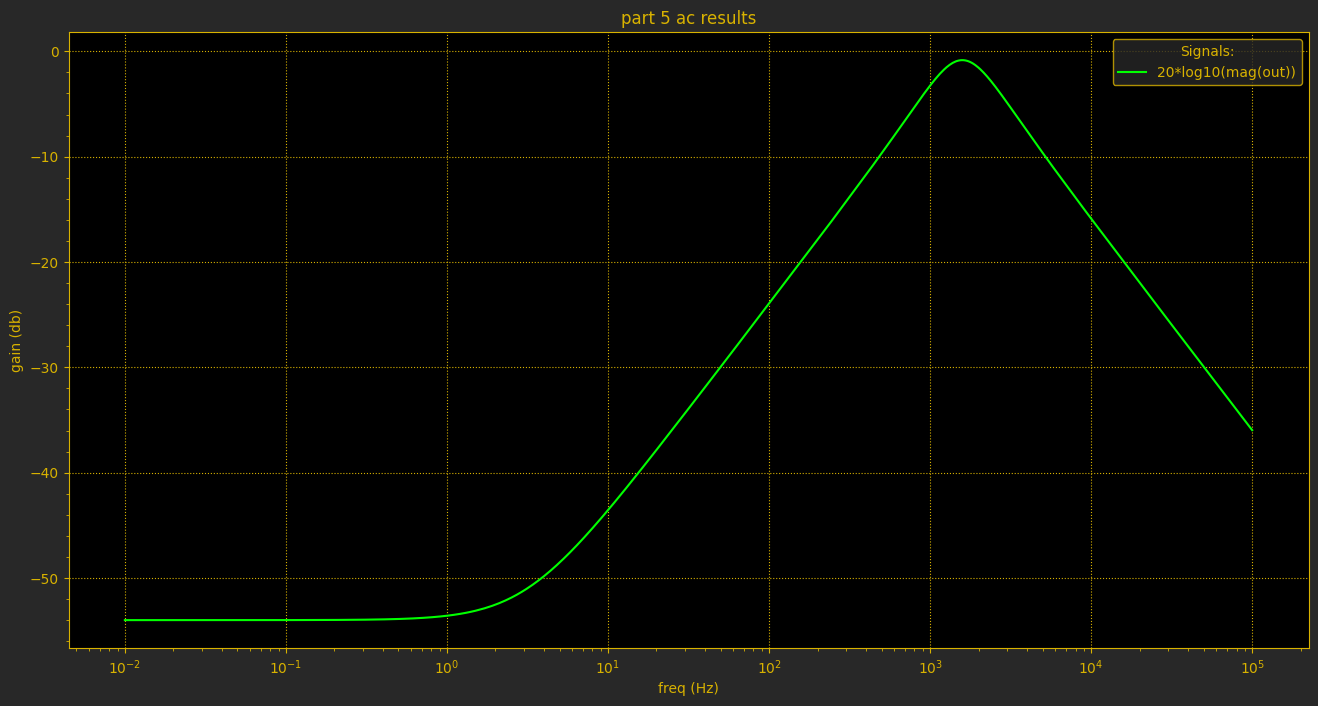


--- Part 5 calculations ---
freq at peak gain: 1584.9 Hz
---------------------------



In [10]:
# Part 5


def part5(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    ac1 = spi.Analyses(
        name="ac1",
        cmd_type="ac",
        cmd="ac dec 100 10m 100k",
        vector=my_vectors_dict[Key.VEC_GAIN],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(ac1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL5] = spi.Netlist(str(my_control))

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP5] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.RC]
        + my_netlists_dict[Key.COUT]
        + my_netlists_dict[Key.LOAD5]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS5]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL5]
        + my_netlists_dict[Key.END_LINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top5.cir"
    my_netlists_dict[Key.TOP5].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim5",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]
    # get waveforms from sim_results
    ac1 = spi.Waveforms(sim_results[0].header, sim_results[0].data_plot,npts=1000000)

    # display results
    plot_data = ac1.x_axis_and_sigs(my_vectors_dict[Key.VEC_GAIN].list_out())
    y_names = my_vectors_dict[Key.VEC_GAIN].list_out()
    my_plt = spi.Plot("ac_plt", plot_data, y_names, my_paths_dict[Key.RESULTS_PATH])
    my_plt.set_title("part 5 ac results")
    my_plt.define_axes(("freq", "Hz", "log"), ("gain", "db", "linear"))
    my_plt.png()  # create png file and send to results directory
    spi.display_plots()

    ac1_numpys: list[numpy_flt] = ac1.x_axis_and_sigs(
        my_vectors_dict[Key.VEC_GAIN].list_out()
    )
    fbegin, fend, npoints = (10e-3, 10e3, 1000000)
    my_meas: spi.StepInfo = spi.StepInfo(
        ac1_numpys[0], ac1_numpys[1], fbegin, fend, npoints
    )
 
    f_peak:float = my_meas.peaktime
    formatted_answer: str = f"freq at peak gain: {f_peak:.5g} Hz"
    spi.print_section("Part 5 calculations", formatted_answer)

    return my_netlists_dict


netlists_dict = part5(paths_dict, netlists_dict, vectors_dict)

In [ ]:
# Part 6


def part6(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    ac1 = spi.Analyses(
        name="tr1",
        cmd_type="tran",
        cmd="tran 0.1u 1m",
        vector=my_vectors_dict[Key.VEC_OUT],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(ac1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL6] = spi.Netlist(str(my_control))

    my_netlists_dict[Key.RF] = spi.Netlist("RF rc beta 100")
    my_netlists_dict[Key.CF] = spi.Netlist("CF rc div 100n")

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP6] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.RF]
        + my_netlists_dict[Key.CF]
        + my_netlists_dict[Key.COUT]
        + my_netlists_dict[Key.LOAD6]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS6]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL6]
        + my_netlists_dict[Key.END_LINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top6.cir"
    my_netlists_dict[Key.TOP6].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim6",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]


    return my_netlists_dict


# netlists_dict = part6(paths_dict, netlists_dict, vectors_dict)

In [ ]:
# Part 7


def part7(
    my_paths_dict: dict[str, Path],
    my_netlists_dict: dict[str, spi.Netlist],
    my_vectors_dict: dict[str, spi.Vectors],
) -> dict[str, spi.Netlist]:

    # Define analyses
    list_of_analyses: list[spi.Analyses] = []  # start with an empty list
    # 1st (and only) analysis: transient analysis
    tr1 = spi.Analyses(
        name="tr1",
        cmd_type="tran",
        cmd="tran 0.1u 1m",
        vector=my_vectors_dict[Key.VEC_OUT],
        results_loc=my_paths_dict[Key.RESULTS_PATH],
    )
    list_of_analyses.append(tr1)

    # create control section
    my_control = spi.Control()  # create 'my_control' object
    for analysis in list_of_analyses:
        my_control.insert_lines(analysis.lines_for_cntl())
    my_netlists_dict[Key.CONTROL7] = spi.Netlist(str(my_control))

    # create comp network with rf = 470k and cf shorted
    my_netlists_dict[Key.RF_470K] = spi.Netlist("RF beta div 470k")
    my_netlists_dict[Key.LOAD7] = spi.Netlist(
        "iload out 0 pwl 0 0.1 100u 0.1 101u 1.0 500u 1.0 501u 0.1"
    )

    # concatenate all tne netlists to make top1 and add to netlist dict
    my_netlists_dict[Key.TOP7] = (
        my_netlists_dict[Key.TITLE]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.DUT]
        + my_netlists_dict[Key.RF_470K]
        + my_netlists_dict[Key.LOAD7]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.SUPPLIES]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.STIMULUS7]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.MODELS]
        + my_netlists_dict[Key.BLANKLINE]
        + my_netlists_dict[Key.CONTROL7]
        + my_netlists_dict[Key.END_LINE]
    )
    # write netlist to a file so ngspice can read it
    top_filename: Path = my_paths_dict[Key.NETLISTS_PATH] / "top7.cir"
    my_netlists_dict[Key.TOP7].write_to_file(top_filename)

    # prepare simulate object, print out command, and simulate
    sim: spi.Simulate = spi.Simulate(
        my_paths_dict[Key.NGSPICE_EXE],
        top_filename,
        my_paths_dict[Key.SIM_TRANSCRIPT_FILENAME],
        "sim7",
    )
    # spi.print_section("Ngspice Command", sim1) # print out command
    sim.run()  # run the Ngspice simulation

    # convert the raw results into list of SimResults objects
    sim_results: list[spi.SimResults] = [
        spi.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
        for analysis in list_of_analyses
    ]

    # give each SimResults object a more descriptive name
    tr1 = sim_results[0]

    # display results
    plot_data = tr1.x_axis_and_sigs(my_vectors_dict[Key.VEC_OUT].list_out())
    y_names = my_vectors_dict[Key.VEC_OUT].list_out()
    my_plt = spi.Plot("tr_plt", plot_data, y_names, my_paths_dict[Key.RESULTS_PATH])
    my_plt.set_title("part 7 transient results")
    my_plt.define_axes(("time", "sec", "linear"), ("voltage", "V", "linear"))
    my_plt.png()  # create png file and send to results directory
    spi.display_plots()

    tr1_numpys: list[numpy_flt] = tr1.x_axis_and_sigs(
        my_vectors_dict[Key.VEC_OUT].list_out()
    )
    tbegin, tend, npoints = (50e-6, 150e-6, 100000)
    my_meas: spi.StepInfo = spi.StepInfo(
        tr1_numpys[0], tr1_numpys[1], tbegin, tend, npoints
    )
    vout_delta: float = my_meas.ydelta
    formatted_answer: str = f"delta vout: {vout_delta:.5g} V"
    spi.print_section("Part 7 calculations", formatted_answer)

    return my_netlists_dict


# netlists_dict = part7(paths_dict, netlists_dict, vectors_dict)

#### Main
Run all the parts at once so the results are together.

Note that with each "part" function the netlist_dict is updated (returned) with the top netlist from each part added to the dictionary.

In [ ]:
# Execute all parts
# netlists_dict = part1(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part2(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part3(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part4(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part5(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part6(paths_dict, netlists_dict, vectors_dict)
# netlists_dict = part7(paths_dict, netlists_dict, vectors_dict)